# Notebook for debugging full SNLI experiments

In [1]:
#general
import sys, os
import tensorflow as tf
import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger(os.path.basename(sys.argv[0]))

#jack
os.chdir('../..') #First change dir to Jack parent
import jtr.jack.readers as readers
from jtr.load.embeddings.embeddings import load_embeddings, Embeddings

#info 
print('current working directory: ', os.getcwd())

from tensorflow.python.client import device_lib
logger.info('available devices:')
for l in device_lib.list_local_devices():
    logger.info('device info: ' + str(l).replace("\n", " "))


current working directory:  /Users/tdmeeste/workspace/jtr
INFO:__main__.py:available devices:
INFO:__main__.py:device info: name: "/cpu:0" device_type: "CPU" memory_limit: 268435456 locality { } incarnation: 17840164850955232819 


### constants

In [2]:
train_file = "./data/SNLI/snli_1.0/snli_1.0_train_jtr_v1.json"
dev_file = "./data/SNLI/snli_1.0/snli_1.0_dev_jtr_v1.json"
test_file = "./data/SNLI/snli_1.0/snli_1.0_test_jtr_v1.json"


### configuration

In [3]:
#experiment mode:
debug = True #only use small part ofdata; train=test=dev
debug_examples = 500  #train set size in case debug

#tensorboard folder
#tensorboard_folder = './.tb/'

#config for preprocessing
lowercase = False
#vocab_sep = True #Should there be separate vocabularies for questions and supports, vs. candidates and answers. This needs to be set to True for candidate-based methods.

#config of Vocab and NeuralVocab
vocab_max_size = sys.maxsize
vocab_min_freq = 2
pretrain = True
#train_pretrain = True
#normalize_pretrain = True
repr_dim_input = 50 if debug else 300
#repr_dim_input_trf = 100
#repr_dim_output = 100

#model -- choices=sorted(reader_models.keys())
#model = bicond_singlesupport_reader 

#model hyperparams
hidden_dim = 100
#dim_rnn_in = 100
#dim_rnn_out = 100


#training
batch_size = 32 if debug else 256
eval_batch_size = 256
learning_rate = 0.001
#l2 = 0.0
#clip_value = 0.0
dropout = 0.0
epochs = 30
#buckets = 1

#misc
seed = 1337
#logfile = ''
#write_metrics_to = ''

In [4]:
config = {
    'batch_size': batch_size,
    'eval_batch_size': eval_batch_size,
    'learning_rate': learning_rate,
    'vocab_min_freq': vocab_min_freq,
    'vocab_max_size': vocab_max_size,
    'lowercase': lowercase,
    'repr_dim_input': repr_dim_input,
    'repr_dim': hidden_dim,
    'dropout': dropout    
}

In [5]:
tf.set_random_seed(seed)

### Load data

In [6]:
from jtr.jack.data_structures import load_labelled_data

snli_data = []
splits = [train_file, dev_file, test_file]
max_count = debug_examples if debug else None

train_set, dev_set, test_set = [load_labelled_data(f, max_count) for f in splits]

for s,l in zip([train_set, dev_set, test_set],['train', 'dev', 'test']):
    print('loaded %d %s instances'%(len(s), l))

loaded 500 train instances
loaded 500 dev instances
loaded 500 test instances


### Load pre-trained embeddings and create vocabulary

In [7]:
from jtr.preprocess.vocab import Vocab

#load pre-trained embeddings
embeddings = None
if pretrain:
    if debug:
        emb_file = 'glove.6B.50d.txt'
        embeddings = load_embeddings(os.path.join('jtr', 'data', 'GloVe', emb_file), 'glove')
    else:
        emb_file = 'GoogleNews-vectors-negative300.bin.gz'
        embeddings = load_embeddings(os.path.join('jtr', 'data', 'SG_GoogleNews', emb_file, 'word2vec'))    
    logger.info('loaded pre-trained embeddings ({})'.format(emb_file))

#create Vocab object
vocab = Vocab(emb=embeddings)


INFO:jtr.load.embeddings.glove:Loading GloVe vectors ..
INFO:jtr.load.embeddings.glove:Loading GloVe vectors completed.
INFO:__main__.py:loaded pre-trained embeddings (glove.6B.50d.txt)


### Create a reader

In [8]:
# Create example reader with a basic config
reader = readers.readers["snli_reader"](vocab, config)

### Add hooks

In [9]:
# We create hooks which keep track of the metrics such as the loss
# We also create a classification metric monitoring hook for our model
from jtr.jack.train.hooks import LossHook
hooks = [LossHook(reader, iter_interval=100),
         readers.eval_hooks['snli_reader'](reader, train_set, iter_interval=100, info='train'),
         readers.eval_hooks['snli_reader'](reader, dev_set, iter_interval=100, info='dev'),
         readers.eval_hooks['snli_reader'](reader, test_set, epoch_interval=epochs, info='test')]

### Initialise optimiser

In [10]:
# Here we initialise our optimiser
# we choose Adam with standard momentum values and learning rate 0.001
optim = tf.train.AdamOptimizer(config['learning_rate'])

### Train reader

In [11]:
# Let's train the reader on the CPU for 2 epochs
reader.train(optim, train_set,
             hooks=hooks, max_epochs=epochs,
             device='/cpu:0')

INFO:jtr.jack.core:Setting up data and model...
DEBUG:jtr.jack.core:Pruned train vocab size (400085 to 1060)
DEBUG:jtr.jack.core:answer_vocab: {'neutral': 1, 'contradiction': 2, 'entailment': 0}
INFO:jtr.jack.core:Start training...
INFO:jtr.jack.train.hooks:Epoch 1	Iter 15	total 500	Accuracy: 0.334	F1_macro: 0.234	train
INFO:jtr.jack.train.hooks:Epoch 1	Iter 15	total 500	Accuracy: 0.346	F1_macro: 0.210	dev
INFO:jtr.jack.train.hooks:Epoch 2	Iter 30	total 500	Accuracy: 0.366	F1_macro: 0.289	train


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:jtr.jack.train.hooks:Epoch 2	Iter 30	total 500	Accuracy: 0.340	F1_macro: 0.262	dev
INFO:jtr.jack.train.hooks:Epoch 3	Iter 45	total 500	Accuracy: 0.360	F1_macro: 0.267	train
INFO:jtr.jack.train.hooks:Epoch 3	Iter 45	total 500	Accuracy: 0.332	F1_macro: 0.210	dev
INFO:jtr.jack.train.hooks:Epoch 4	Iter 60	total 500	Accuracy: 0.392	F1_macro: 0.317	train
INFO:jtr.jack.train.hooks:Epoch 4	Iter 60	total 500	Accuracy: 0.378	F1_macro: 0.267	dev
INFO:jtr.jack.train.hooks:Epoch 5	Iter 75	total 500	Accuracy: 0.456	F1_macro: 0.436	train
INFO:jtr.jack.train.hooks:Epoch 5	Iter 75	total 500	Accuracy: 0.436	F1_macro: 0.407	dev
INFO:jtr.jack.train.hooks:Epoch 6	Iter 90	total 500	Accuracy: 0.472	F1_macro: 0.408	train
INFO:jtr.jack.train.hooks:Epoch 6	Iter 90	total 500	Accuracy: 0.432	F1_macro: 0.364	dev
INFO:jtr.jack.train.hooks:Epoch 7	Iter 100	Loss 1.08164277852
INFO:jtr.jack.train.hooks:Epoch 7	Iter 100	total 500	Accuracy: 0.482	F1_macro: 0.476	train
INFO:jtr.jack.train.hooks:Epoch 7	Iter 100	tota

### Plotting the results

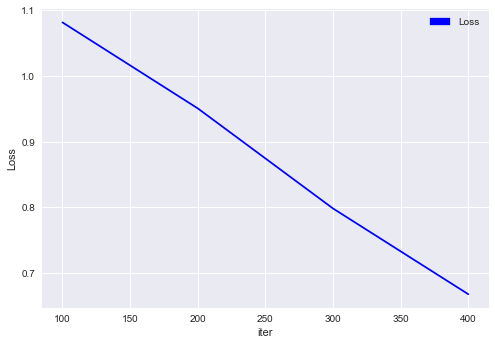

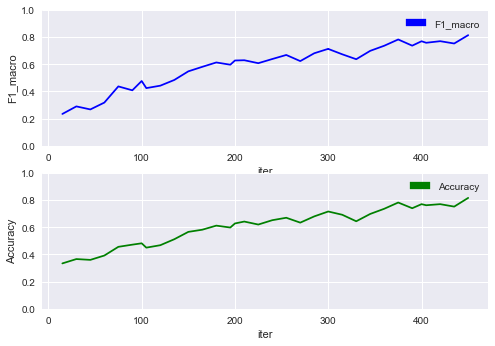

In [12]:
# This plots the loss
hooks[0].plot()
# This plots the F1 (macro) score and accuracy between 0 and 1
hooks[1].plot(ylim=[0.0, 1.0])

### Analysing errors

In [13]:
# We can analyse what our model is doing by using the MisclassificationAnalyzerOutputModule.
#from jtr.jack.tasks.mcqa.simple_mcqa import MisclassificationOutputModule   

# We want misclassifications where the model predicted a probability between 0 and 0.2, 
# and we want to print 10 examples
#reader.output_module = MisclassificationOutputModule(interval=[0.0, 0.20], limit=10)                                                                                                                     
#reader.process_outputs(test_set) # run the output module on the test set
# From the output below we can see that our model still has problems to distinguishe between neutral and
# entailment between premise and hypothesis